In [1]:
import cPickle
import string
import pandas as pd
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
import tqdm
import seaborn as sns
import gc
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import model_eval

%matplotlib inline


DATA_TRAIN_PATH = '../input/train.csv'
DATA_TEST_PATH = '../input/test.csv'
LIN_DATA_TRAIN_PATH = '../input/lin_train.csv'
LIN_DATA_TEST_PATH = '../input/lin_test.csv'
IMG_PATH = '../images/'

### These variables perform better with OHE
ohe_list = ['cat73', 'cat93', 'cat112']

### These dicts are to re-encode cat112 to state abbreviations
swap_to_num = {'cat112': {'A': 0, 'AA': 25, 'AB': 26, 'AC': 27, 'AD': 28,
'AE': 29, 'AF': 30, 'AG': 31, 'AH': 32, 'AI': 33, 'AJ': 34, 'AK': 35, 'AL': 36,
'AM': 37, 'AN': 38, 'AO': 39, 'AP': 40, 'AQ': 41, 'AR': 42, 'AS': 43, 'AT': 44,
'AU': 45, 'AV': 46, 'AW': 47, 'AX': 48, 'AY': 49, 'B': 1, 'BA': 50, 'C': 2,
'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11,
'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19,
'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24}}

swap_to_state = {'cat112': {0: 'AL', 1: 'AK', 2: 'AZ', 3: 'AR', 4: 'CA',
5: 'CO', 6: 'CT', 7: 'DE', 8: 'DC', 9: 'FL', 10: 'GA', 11: 'HI', 12: 'ID',
13: 'IL', 14: 'IN', 15: 'IA', 16: 'KS', 17: 'KY', 18: 'LA', 19: 'ME', 20: 'MD',
21: 'MA', 22: 'MI', 23: 'MN', 24: 'MS', 25: 'MO', 26: 'MT', 27: 'NE', 28: 'NV',
29: 'NH', 30: 'NJ', 31: 'NM', 32: 'NY', 33: 'NC', 34: 'ND', 35: 'OH', 36: 'OK',
37: 'OR', 38: 'PA', 39: 'RI', 40: 'SC', 41: 'SD', 42: 'TN', 43: 'TX', 44: 'UT',
45: 'VT', 46: 'VA', 47: 'WA', 48: 'WV', 49: 'WI', 50: 'WY'}}

### Helper functions
def convert_cat_to_num(data):
    translation = list(string.ascii_uppercase)[:-1]
    for elem_i in translation[:13]:
        for elem_j in translation[:25]:
            translation.append(elem_i + elem_j)
    for i in range(len(translation)):
        data.replace(translation[i], i, inplace=True)
    data.replace('ZZ', -1, inplace=True)
    return


### Read the data in and prepare
log_y = 436.28279443805883
train = pd.read_csv(DATA_TRAIN_PATH, dtype={'id': np.int32})
train = train.replace(swap_to_num).replace(swap_to_state)
train = pd.get_dummies(train, columns=ohe_list)
convert_cat_to_num(train)
train['logloss'] = np.log(train['loss']+log_y)
test = pd.read_csv(DATA_TEST_PATH, dtype={'id': np.int32})
test = test.replace(swap_to_num).replace(swap_to_state)
test = pd.get_dummies(test, columns=ohe_list)
convert_cat_to_num(test)
ntrain = train.shape[0]
ntest = test.shape[0]
train_test = pd.concat((train, test)).reset_index(drop=True)
num_feats = [feat for feat in test.columns if 'cont' in feat]
#lin_feats = [feat for feat in test.columns if 'lin' in feat]
#for col in lin_feats:
#    train[col] = train[col]/float(train_test[col].max())

cat_feats = [feat for feat in test.columns if 'cat' in feat]
prob_ordered=[]
for elem in cat_feats:
    if train_test[elem].nunique()!=train_test[elem].max()+1:
        prob_ordered.append(elem)

C:\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using Theano backend.


In [5]:
folds = 5
early_stop = 40
### Through HyperOpt, found best log_y value to be 
log_y = 436.28279443805883

scores = {}

scores['base_log'] = model_eval.xgb_quick_eval(train.drop(['loss','logloss'], axis=1),
    np.log(train['loss']+log_y), folds=folds, log_y=log_y, booster='gbtree', early_stop=early_stop)

[0]	train-mae:6.67231	eval-mae:6.67347
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 40 rounds.
[200]	train-mae:0.31778	eval-mae:0.335726
[400]	train-mae:0.30575	eval-mae:0.334385
Stopping. Best iteration:
[447]	train-mae:0.303322	eval-mae:0.334205

Average eval-MAE: 1147.887799

Means: actual=3037.33768567, predicted=2722.70825195
Medians: actual=2115.57, predicted=2060.03076172
 Time taken: 2.0 min and 5.48 sec


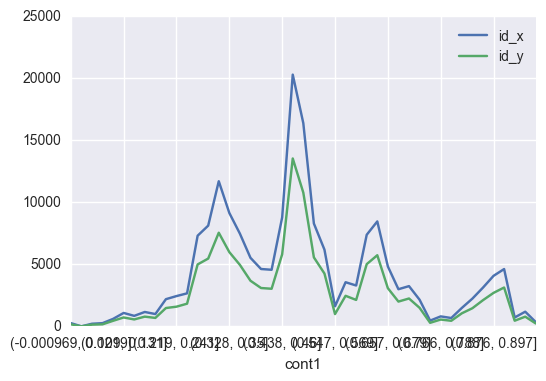

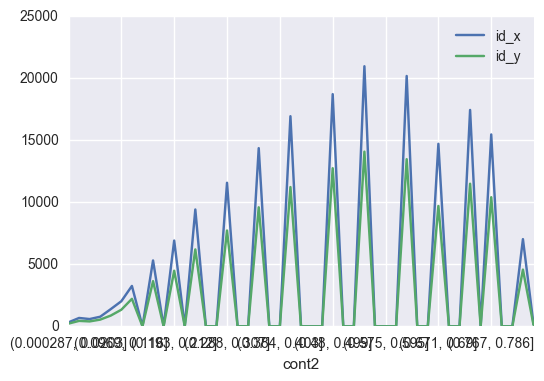

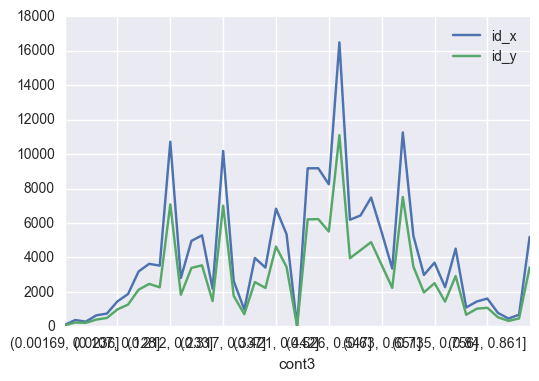

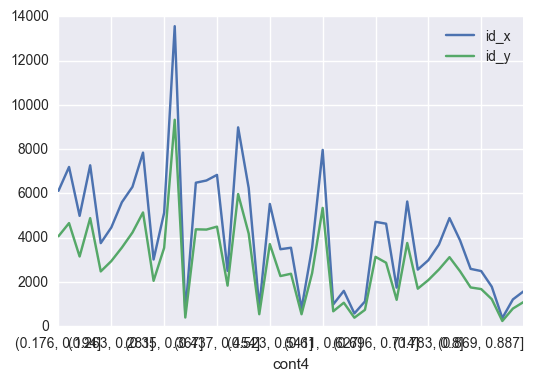

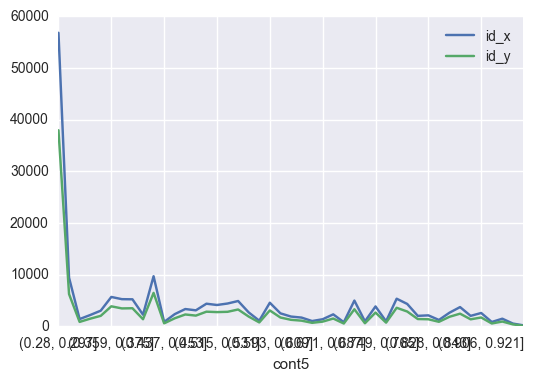

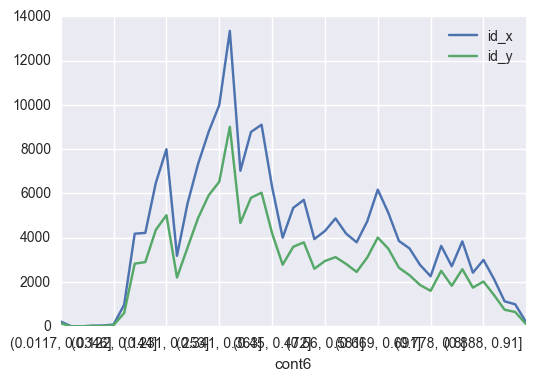

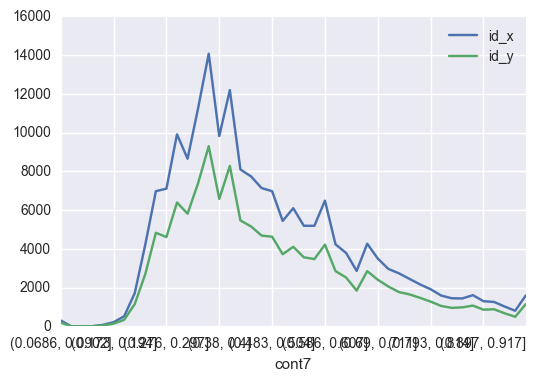

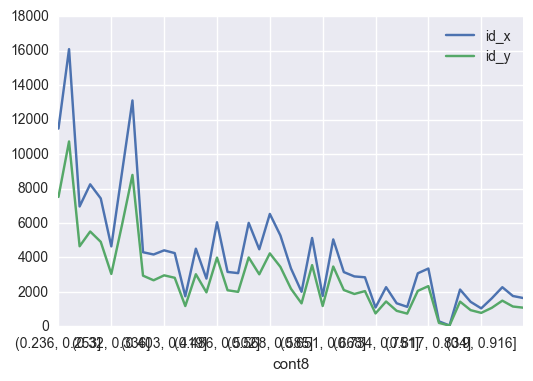

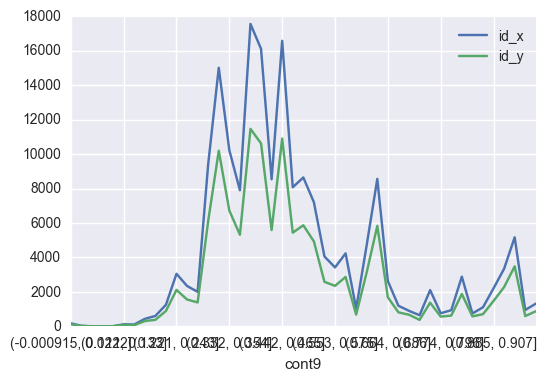

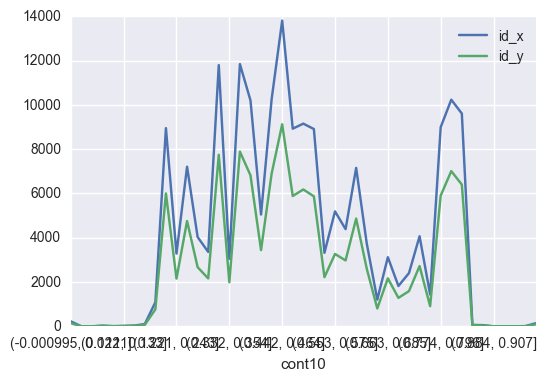

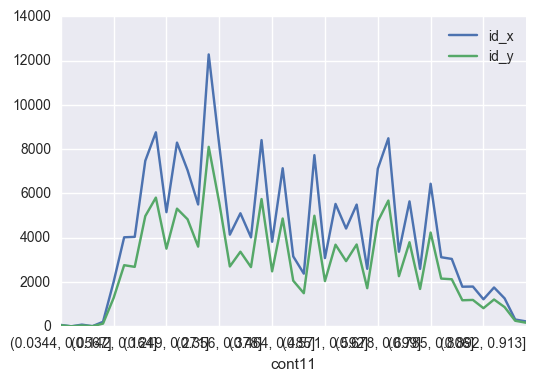

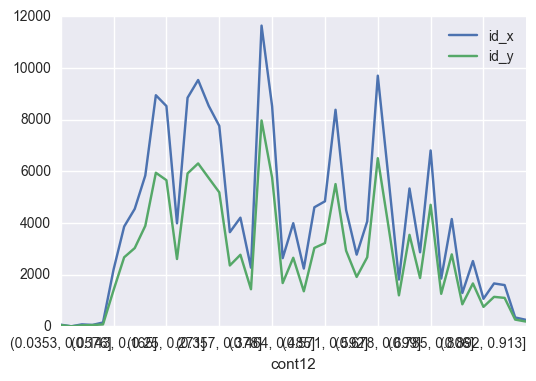

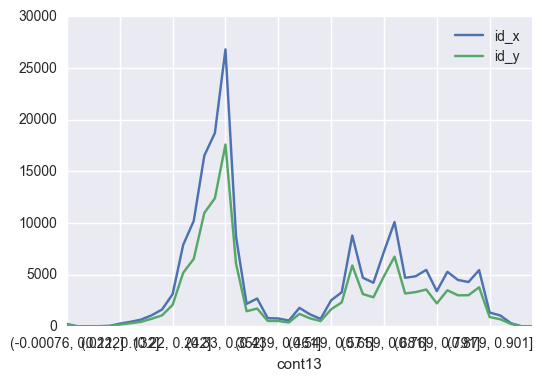

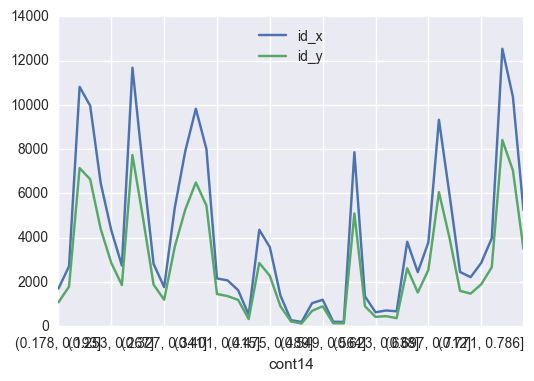

In [6]:
for col in num_feats:
    train_test[col] = pd.cut(train_test[col], bins=45)
    #train_counts = train_test[train_test.loss.isnull()][col].value_counts()
    #test_counts = train_test[~(train_test.loss.isnull())][col].value_counts()
    #plt.plot()
    binned_test = train_test[train_test.loss.isnull()][[col,'id']].groupby(by=col)
    binned_train = train_test[~(train_test.loss.isnull())][[col,'id']].groupby(by=col)
    binned = binned_train.count()
    binned = binned.merge(binned_test.count(), left_index=True, right_index=True, how='left')
    binned.plot()

It appears that distributions of train and test are similar. Now encode bins with mean loss (maybe try median, quantiles, or a vaue from each bins distribution).

In [2]:
def encode_cont(train_test, cont_feats):
    for col in cont_feats:
        train_test[col+'_binned'] = pd.cut(train_test[col], bins=45)
        binned = train_test[[col+'_binned','logloss']].groupby(by=col+'_binned')
        binned_mean = binned.mean().rename(columns={'logloss': col+'_bin_mean'})
        binned_std = binned.std()
        binned_quantiles = binned.quantile([.25,.5,.75]).unstack().rename(columns={.25:col+'_.25',.5:col+'_.5',.75:col+'_.75'})
        binned_mean = binned_mean.merge(binned_quantiles, right_index=True, left_index=True, how='left')
        #print binned_mean.head()
        train_test = train_test.merge(binned_mean, left_on=col+'_binned', right_index=True, how='left')
        train_test.drop(col+'_binned', 1, inplace=True)
    return train_test

In [3]:
train_test = pd.concat((train, test)).reset_index(drop=True)
train_test = encode_cont(train_test, num_feats)
#train_test.cont1_mean.head(50)

C:\Anaconda2\lib\site-packages\pandas\tools\merge.py:489: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


                     cont1_bin_mean  (logloss, cont1_.25)  \
cont1_binned                                                
(-0.000969, 0.0219]        8.089034              7.490531   
(0.0219, 0.0438]                NaN                   NaN   
(0.0438, 0.0657]           8.047499              7.579057   
(0.0657, 0.0876]           8.067343              7.457755   
(0.0876, 0.109]            7.897146              7.423385   

                     (logloss, cont1_.5)  (logloss, cont1_.75)  
cont1_binned                                                    
(-0.000969, 0.0219]             8.008440              8.615868  
(0.0219, 0.0438]                     NaN                   NaN  
(0.0438, 0.0657]                8.091784              8.508224  
(0.0657, 0.0876]                7.991914              8.572652  
(0.0876, 0.109]                 7.903043              8.345059  
                    cont2_bin_mean  (logloss, cont2_.25)  (logloss, cont2_.5)  \
cont2_binned                        

In [9]:
for col in num_feats:
    print col+'_bin_mean', ' : ', train_test[col+'_bin_mean'].count()
print 'Total         ', ' : ', train_test.id.count()

cont1_bin_mean  :  313864
cont2_bin_mean  :  313864
cont3_bin_mean  :  313864
cont4_bin_mean  :  313864
cont5_bin_mean  :  313864
cont6_bin_mean  :  313864
cont7_bin_mean  :  313864
cont8_bin_mean  :  313864
cont9_bin_mean  :  313864
cont10_bin_mean  :  313864
cont11_bin_mean  :  313864
cont12_bin_mean  :  313864
cont13_bin_mean  :  313864
cont14_bin_mean  :  313864
Total           :  313864


Looks like they all made it into bins!

In [4]:
train = train_test[~(train_test.loss.isnull())]
test = train_test[train_test.loss.isnull()]

In [25]:
folds = 5
early_stop = 40
### Through HyperOpt, found best log_y value to be 
log_y = 436.28279443805883

scores = {}

scores['base_log'] = model_eval.xgb_quick_eval(train.drop(['loss','logloss'], axis=1),
    np.log(train['loss']+log_y), folds=folds, log_y=log_y, booster='gbtree', early_stop=early_stop)

[0]	train-mae:6.67242	eval-mae:6.67369
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 40 rounds.
[100]	train-mae:0.322094	eval-mae:0.338431
[200]	train-mae:0.306422	eval-mae:0.336444
[300]	train-mae:0.294005	eval-mae:0.336237
Stopping. Best iteration:
[268]	train-mae:0.297422	eval-mae:0.336085

Average eval-MAE: 1154.864008

Means: actual=3037.33768567, predicted=2724.56591797
Medians: actual=2115.57, predicted=2070.94238281
 Time taken: 3.0 min and 39.27 sec


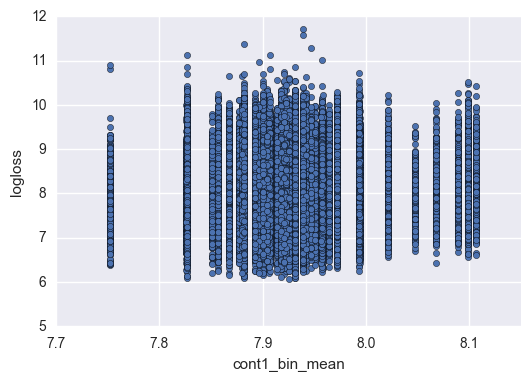

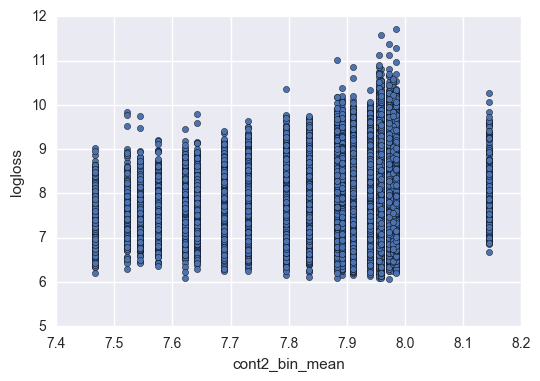

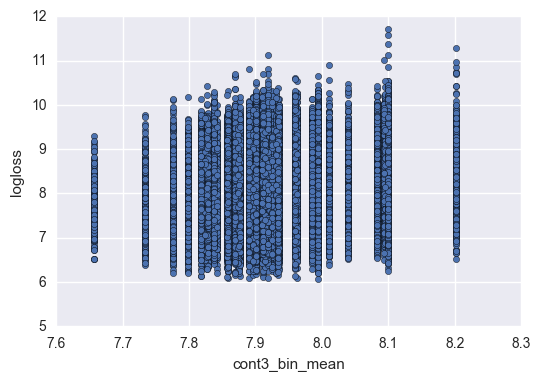

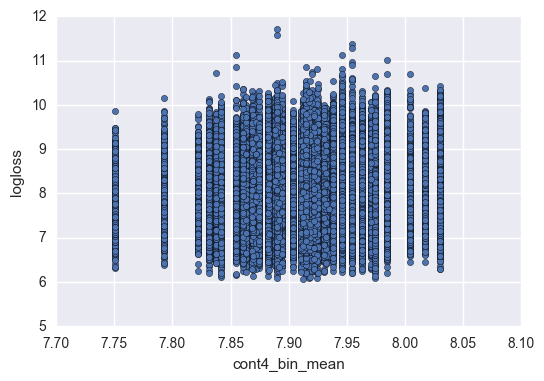

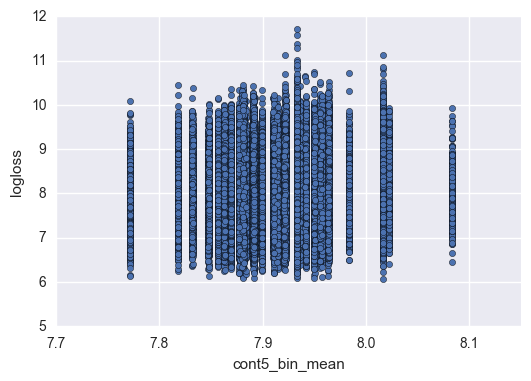

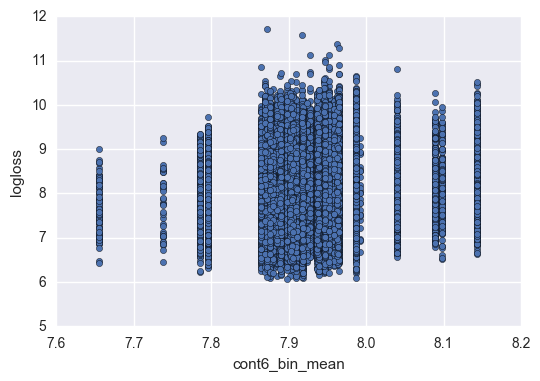

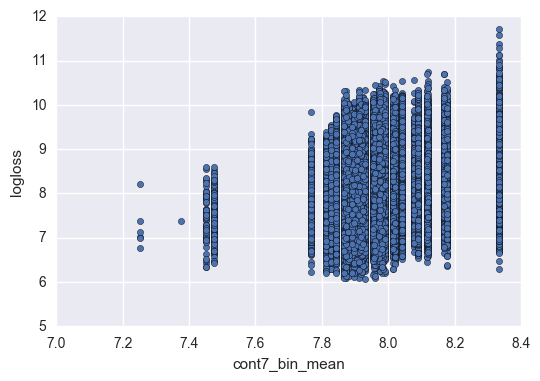

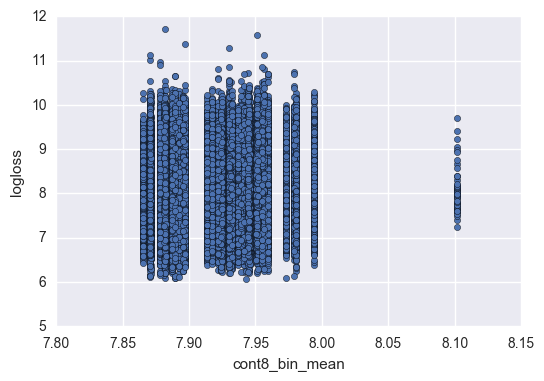

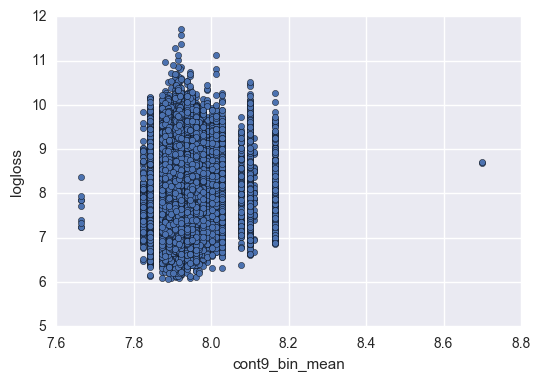

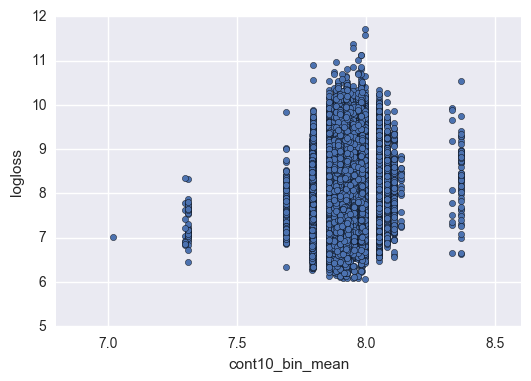

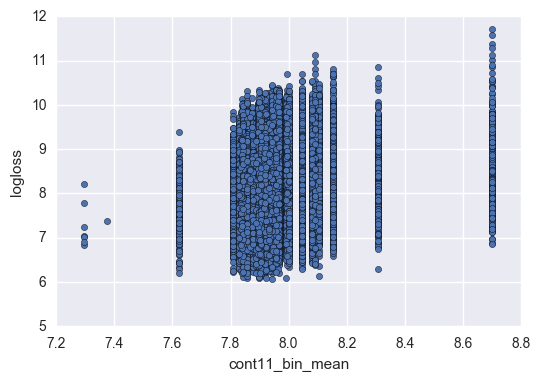

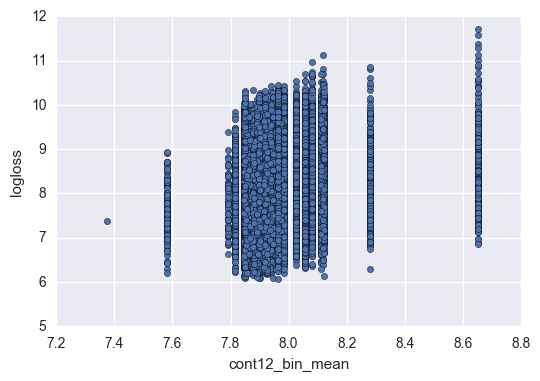

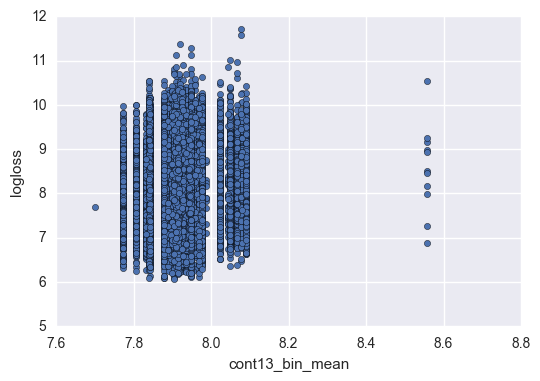

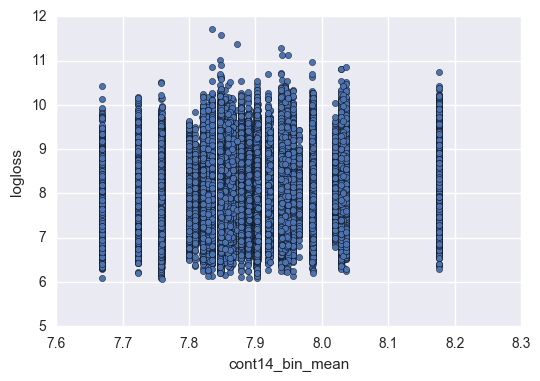

In [6]:
for col in num_feats:
    train.plot.scatter(col+'_bin_mean', 'logloss')